In [2]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

import scipy.constants as constants
import scipy.special as special

from qutip import *

def eval_rabi_freq(nStart, nDelta, eta):
    """
    Calculates Rabi Frequency for nStart -> nStart + nDelta

    Args:
        nStart (int): Initial phonon state
        nDelta (int): Change in phonon number
        eta (float): Lamb-Dicke Parameter

    Returns:
        float: Rabi frequency
    """
    nEnd = nStart + nDelta

    nSmall = min([nStart, nEnd])
    nBig = max([nStart, nEnd])
    factor2 = np.exp(-0.5 * eta**2) * eta**(np.absolute(nDelta))
    factor3 = np.sqrt(np.math.factorial(nSmall)/np.math.factorial(nBig))
    factor4 = special.assoc_laguerre(eta**2, nSmall, np.absolute(nDelta))

    return factor2 * factor3 * factor4

# Max Fock State
N = 10

### Three-ion System Set-up

In [3]:
#https://www.nature.com/articles/s41467-018-08090-0
# --------------------- Rabi Frequenies --------------------
ax_freq = 0.404
r1_freq = 1.093
r2_freq = 1.375

ax_modes = [ax_freq, np.sqrt(3) * ax_freq, np.sqrt(29/5) * ax_freq]
r1_modes = [r1_freq, np.sqrt(r1_freq**2 - ax_freq**2), np.sqrt(r1_freq**2 - (12/5) * ax_freq**2)]
r2_modes = [r2_freq, np.sqrt(r2_freq**2 - ax_freq**2), np.sqrt(r2_freq**2 - (12/5) * ax_freq**2)]

# --------------------- Lamb-Dicke Parameteres --------------------
ax_ld_param = 0.26
r1_ld_param = 0.1
r2_ld_param = 0.1

def generate_ld_matrix(ld_param):
    """
    Generate 3x3 matrix containing the Lamb-Dicke parameters for 3 ions for the 3 modes of motion along each axis.
    
    Rows label modes
    Columns label the ions
    
    E.g) matrix[1][2]
        Row = 1 -> OP1 Mode
        Column = 2 -> 3rd Ion
    """
    matrix = np.empty([3, 3])
    
    for i in range(3):
        if i == 0: # Center-of-Mass Motion
            for j in range(3):
                matrix[i][j] = ld_param
        elif i == 1: # OP1
            matrix[i][0] = (ld_param * np.sqrt(3))/np.sqrt(2)
            matrix[i][1] = 0
            matrix[i][2] = (ld_param * np.sqrt(3))/np.sqrt(2)
        else:   # OP2
            matrix[i][0] = (ld_param * np.sqrt(3))/np.sqrt(6)
            matrix[i][1] = -2 * (ld_param * np.sqrt(3))/np.sqrt(6)
            matrix[i][2] = (ld_param * np.sqrt(3))/np.sqrt(6)
    
    return matrix     

ax_ld = generate_ld_matrix(ax_ld_param)
r1_ld = generate_ld_matrix(r1_ld_param)
r2_ld = generate_ld_matrix(r2_ld_param)

# --------------------- Experimental Parameters --------------------
carr_rabi = 0.3 # Approximate value for 10us pi-time

In [8]:
# --------------------- Operators --------------------
a_ion1_ax_com = tensor(qeye(2), qeye(2), qeye(2), destroy(N), qeye(N * 8))
a_ion1_ax_op1 = tensor(qeye(2), qeye(2), qeye(2), qeye(N), destroy(N), qeye(N * 7))

print(a_ion1_ax_com)
print(a_ion1_ax_op1)


Quantum object: dims = [[2, 2, 2, 10, 80], [2, 2, 2, 10, 80]], shape = (6400, 6400), type = oper, isherm = False
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Quantum object: dims = [[2, 2, 2, 10, 10, 70], [2, 2, 2, 10, 10, 70]], shape = (56000, 56000), type = oper, isherm = False
Qobj data =
  (0, 70)	(1+0j)
  (1, 71)	(1+0j)
  (2, 72)	(1+0j)
  (3, 73)	(1+0j)
  (4, 74)	(1+0j)
  (5, 75)	(1+0j)
  (6, 76)	(1+0j)
  (7, 77)	(1+0j)
  (8, 78)	(1+0j)
  (9, 79)	(1+0j)
  (10, 80)	(1+0j)
  (11, 81)	(1+0j)
  (12, 82)	(1+0j)
  (13, 83)	(1+0j)
  (14, 84)	(1+0j)
  (15, 85)	(1+0j)
  (16, 86)	(1+0j)
  (17, 87)	(1+0j)
  (18, 88)	(1+0j)
  (19, 89)	(1+0j)
  (20, 90)	(1+0j)
  (21, 91)	(1+0j)
  (22, 92)	(1+0j)
  (23, 93)	(1+0j)
  (24, 94)	(1+0j)
  :	:
  (55905, 55975)	(3+0j)
  (55906, 55976)	(3+0j)
  (55907, 55977)	(3+0j)
  (55908, 55978)	(3+0j)
  (55909, 55979)	(3+0j)
  (55910, 55980)	(

### On resonance with single mode, no contributions from untargeted modes

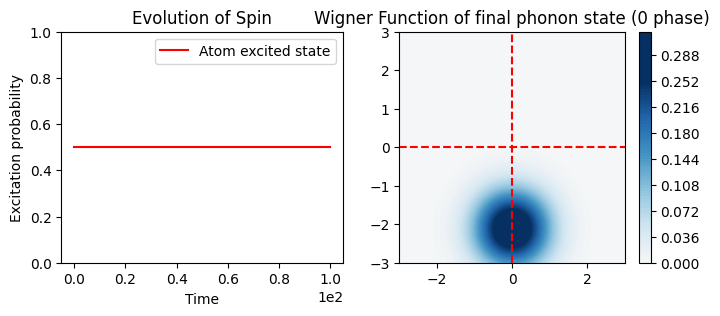

In [23]:
# ---------- Parameters ---------- #
rsb_rabi = carr_rabi * eval_rabi_freq(1, -1, ld_param)
bsb_rabi = carr_rabi * eval_rabi_freq(0, 1, ld_param)

rsb_phase = 0
bsb_phase = 0

# ---------- Hamiltonians ---------- #
# Subscript p refers to the Hermitian Conjugate
RSB = (rsb_rabi/ 2) * a * sm.dag() * np.exp(1j * rsb_phase)
RSBp = (rsb_rabi/ 2) * a.dag() * sm * np.exp(-1j * rsb_phase)

BSB = (bsb_rabi/ 2) * a.dag() * sm.dag() * np.exp(1j * bsb_phase)
BSBp = (bsb_rabi/ 2) * a * sm * np.exp(-1j * bsb_phase)

# ---------- Time Evolution ----------#
t = np.linspace(0, 100, 1001)

H = [RSB, RSBp, BSB, BSBp]

# ---------- Initial State ---------- #
psi0 = tensor((basis(2,0) + basis(2,1)), basis(N, 0))  # Initialise in |+> |0> state.

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a, sm.dag() * sm])
n_phonon = output.expect[0]
n_ion = output.expect[1]

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(t, n_ion, 'r-', label="Atom excited state")
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Excitation probability")
axes[0].set_title("Evolution of Spin")

# Pi-time is where phonon population is maximum
tt = np.where(n_phonon == max(n_phonon))[0][0]

output = mesolve(H = H, rho0 = psi0, tlist = t)
rho_check = output.states[tt]

xvec = np.linspace(-3, 3, 200)
rho_phonon_check = ptrace(rho_check, 1)
W = wigner(rho_phonon_check, xvec, xvec)

im = axes[1].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[1].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[1].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
axes[1].set_title("Wigner Function of final phonon state (0 phase)")
plt.colorbar(im)
